# IT Service Ticket Classification

## Objetivo

Desenvolver um sistema de classificação automática de tickets de suporte de TI que:
- **Entrada:** texto do ticket (string)
- **Saída:** `{"classe": "...", "justificativa": "..."}`

## Dataset

Utilizamos o dataset [IT Service Ticket Classification](https://www.kaggle.com/datasets/adisongoh/it-service-ticket-classification-dataset), que contém ~48.000 tickets de suporte de TI rotulados em 8 categorias.

---

# 1. Análise Exploratória dos Dados

Antes de implementar o sistema de classificação, é essencial compreender a estrutura dos dados, a distribuição das classes e as características dos textos.

In [55]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter

## 1.1 Carregamento dos Dados

In [56]:
df = pd.read_csv("dataset.csv")
print(f"Total de tickets: {len(df):,}")
print(f"Colunas: {list(df.columns)}")
df.head(10)

Total de tickets: 47,837
Colunas: ['Document', 'Topic_group']


,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous
5,mail please dear looks blacklisted receiving m...,Miscellaneous
6,prod servers tunneling prod tunneling va la tu...,Hardware
7,access request dear modules report report cost...,HR Support
8,reset passwords for our client and passwords c...,Access
9,direct reports missing time please action repo...,HR Support


O dataset possui duas colunas:
- **Document**: O texto do ticket de suporte
- **Topic_group**: A categoria/classe do ticket

## 1.2 Qualidade dos Dados

In [57]:
print("Informações do DataFrame:")
print("-" * 40)
df.info()

Informações do DataFrame:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47837 entries, 0 to 47836
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Document     47837 non-null  object
 1   Topic_group  47837 non-null  object
dtypes: object(2)
memory usage: 747.6+ KB


In [58]:
print("Valores nulos por coluna:")
print(df.isnull().sum())
print(f"\nTotal de valores nulos: {df.isnull().sum().sum()}")

Valores nulos por coluna:
Document       0
Topic_group    0
dtype: int64

Total de valores nulos: 0


In [59]:
print("Valores duplicados:")
duplicates = df.duplicated().sum()
print(f"Tickets duplicados: {duplicates} ({duplicates/len(df)*100:.2f}%)")

Valores duplicados:
Tickets duplicados: 0 (0.00%)


## 1.3 Distribuição das Classes

In [60]:
class_counts = df["Topic_group"].value_counts().reset_index()
class_counts.columns = ["Classe", "Quantidade"]
class_counts["Percentual"] = (class_counts["Quantidade"] / len(df) * 100).round(2)
class_counts

,Classe,Quantidade,Percentual
0,Hardware,13617,28.47
1,HR Support,10915,22.82
2,Access,7125,14.89
3,Miscellaneous,7060,14.76
4,Storage,2777,5.81
5,Purchase,2464,5.15
6,Internal Project,2119,4.43
7,Administrative rights,1760,3.68


In [61]:
fig = px.bar(
    class_counts,
    x="Classe",
    y="Quantidade",
    color="Classe",
    title="Distribuição de Tickets por Classe",
    text="Quantidade",
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_traces(textposition="outside")
fig.update_layout(
    xaxis_title="Classe",
    yaxis_title="Quantidade de Tickets",
    showlegend=False,
    height=500
)
fig.show()

In [62]:
fig = px.pie(
    class_counts,
    values="Quantidade",
    names="Classe",
    title="Proporção de Tickets por Classe",
    color_discrete_sequence=px.colors.qualitative.Set2,
    hole=0.3
)
fig.update_traces(textposition="inside", textinfo="percent+label")
fig.update_layout(height=500)
fig.show()

#### Observações sobre a distribuição

- Dataset **desbalanceado**: Hardware e HR Support representam ~51% dos dados
- As classes menores (Administrative rights, Internal Project) têm menos de 5% cada
- Total de **8 classes** distintas para classificação

#### Implicações para o modelo de classificação

1. **Amostragem para avaliação**: Para avaliar em 200 tickets, devemos usar amostragem estratificada para garantir representação de todas as classes.

2. **RAG e exemplos**: O retriever terá mais exemplos de classes majoritárias. Isso pode ser benéfico (mais contexto) ou problemático (viés).

## 1.4 Análise do Texto dos Tickets

In [63]:
df["text_length"] = df["Document"].str.len()
df["word_count"] = df["Document"].str.split().str.len()

print("Estatísticas da contagem de palavras:")
print(df["word_count"].describe().round(2))

Estatísticas da contagem de palavras:
count    47837.00
mean        43.60
std         56.74
min          2.00
25%         17.00
50%         26.00
75%         46.00
max        981.00
Name: word_count, dtype: float64


In [64]:
fig = px.histogram(
    df,
    x="word_count",
    nbins=50,
    title="Distribuição da Quantidade de Palavras por Ticket",
    color_discrete_sequence=["#66c2a5"]
)
fig.update_layout(
    xaxis_title="Quantidade de Palavras",
    yaxis_title="Frequência",
    height=400
)
fig.show()

In [65]:
# Percentis para entender melhor a distribuição
percentiles = [50, 75, 90, 95, 99]
print("Percentis de palavras por ticket:")
for p in percentiles:
    value = df["word_count"].quantile(p/100)
    print(f"  {p}%: {value:.0f} palavras")

Percentis de palavras por ticket:
  50%: 26 palavras
  75%: 46 palavras
  90%: 91 palavras
  95%: 136 palavras
  99%: 284 palavras


### Discussão: Distribuição do Tamanho dos Textos

A distribuição apresenta assimetria positiva:
- A mediana é significativamente menor que a média, indicando que a maioria dos tickets é curta
- Existem outliers com textos muito longos

In [66]:
fig = px.box(
    df,
    x="Topic_group",
    y="word_count",
    color="Topic_group",
    title="Distribuição de Palavras por Classe",
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_layout(
    xaxis_title="Classe",
    yaxis_title="Quantidade de Palavras",
    showlegend=False,
    height=500
)
fig.show()

In [67]:
# Estatísticas por classe
stats_by_class = df.groupby("Topic_group")["word_count"].agg(["mean", "median", "std"]).round(1)
stats_by_class = stats_by_class.sort_values("mean", ascending=False)
stats_by_class

,mean,median,std
Topic_group,,,
Hardware,56.3,32.0,75.5
Administrative rights,50.4,30.0,63.9
Miscellaneous,43.0,27.0,52.2
HR Support,37.8,24.0,42.3
Internal Project,37.7,24.0,44.6
Access,35.6,22.0,47.2
Purchase,34.9,30.0,25.9
Storage,34.4,21.0,42.9


## 1.5 Análise de Palavras Frequentes

In [68]:
all_words = " ".join(df["Document"]).lower().split()
word_freq = Counter(all_words)

print(f"Vocabulário total: {len(word_freq):,} palavras únicas")
print(f"Total de palavras: {len(all_words):,}")

top_words = pd.DataFrame(word_freq.most_common(30), columns=["Palavra", "Frequência"])
top_words

Vocabulário total: 12,327 palavras únicas
Total de palavras: 2,085,566


,Palavra,Frequência
0,please,70212
1,pm,28902
2,hi,28498
3,regards,27212
4,thank,24962
5,for,24456
6,hello,23025
7,you,21828
8,re,21034
9,thanks,19852


In [69]:
fig = px.bar(
    top_words,
    x="Frequência",
    y="Palavra",
    orientation="h",
    title="Top 30 Palavras Mais Frequentes",
    color="Frequência",
    color_continuous_scale="Viridis"
)
fig.update_layout(
    yaxis={"categoryorder": "total ascending"},
    height=700,
    showlegend=False
)
fig.show()

## 1.6 Palavras Frequentes por Classe

In [70]:
def get_top_words_by_class(df, class_name, n=10):
    class_text = " ".join(df[df["Topic_group"] == class_name]["Document"]).lower().split()
    return Counter(class_text).most_common(n)

classes = df["Topic_group"].unique()
top_words_by_class = []

for cls in classes:
    for word, freq in get_top_words_by_class(df, cls, 10):
        top_words_by_class.append({"Classe": cls, "Palavra": word, "Frequência": freq})

df_top_words = pd.DataFrame(top_words_by_class)

In [71]:
fig = px.bar(
    df_top_words,
    x="Frequência",
    y="Palavra",
    color="Classe",
    facet_col="Classe",
    facet_col_wrap=4,
    orientation="h",
    title="Top 10 Palavras por Classe",
    color_discrete_sequence=px.colors.qualitative.Set2,
    height=800
)
fig.update_layout(showlegend=False)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

## 1.7 Exemplos de Tickets por Classe

In [72]:
for cls in sorted(df["Topic_group"].unique()):
    count = len(df[df["Topic_group"] == cls])
    pct = count / len(df) * 100
    print(f"\n{'='*80}")
    print(f"CLASSE: {cls.upper()} ({count:,} tickets - {pct:.1f}%)")
    print("="*80)
    samples = df[df["Topic_group"] == cls].sample(2, random_state=42)
    for i, (_, row) in enumerate(samples.iterrows(), 1):
        text = row['Document']
        truncated = text[:300] + "..." if len(text) > 300 else text
        print(f"\n[Exemplo {i}]")
        print(truncated)


CLASSE: ACCESS (7,125 tickets - 14.9%)

[Exemplo 1]
confluence access for wednesday february pm confluence please confluence thanks

[Exemplo 2]
password reset open access dear can you please help with rights for laptop order reset password going expire few days have mention working remote location be around december st also have issues connecting open due rights restrictions you think we could fix somehow best regards

CLASSE: ADMINISTRATIVE RIGHTS (1,760 tickets - 3.7%)

[Exemplo 1]
set up and swap leased for new set up swap leased for

[Exemplo 2]
windows upgrade failed upgrade failed hello please raise ticket for issue below upgrade error thank you kind regards infrastructure manager ext phone sent friday upgrade failed hello sorry bother you can anyone help with upgrade regard developer en sent wednesday upgrade failed hello updating operat...

CLASSE: HR SUPPORT (10,915 tickets - 22.8%)

[Exemplo 1]
access to new pas friday february hi guys please rights involved level thanks di

## 1.8 Resumo da Análise Exploratória

In [73]:
print("=" * 60)
print("RESUMO DA ANÁLISE")
print("=" * 60)

print(f"\n[Dataset]")
print(f"  Total de tickets: {len(df):,}")
print(f"  Número de classes: {df['Topic_group'].nunique()}")
print(f"  Sem valores nulos ou duplicados")

print(f"\n[Texto]")
print(f"  Média de palavras: {df['word_count'].mean():.1f}")
print(f"  Mediana de palavras: {df['word_count'].median():.1f}")
print(f"  Máximo de palavras: {df['word_count'].max()}")

print(f"\n[Distribuição das Classes]")
for _, row in class_counts.iterrows():
    print(f"  {row['Classe']}: {row['Quantidade']:,} ({row['Percentual']}%)")

RESUMO DA ANÁLISE

[Dataset]
  Total de tickets: 47,837
  Número de classes: 8
  Sem valores nulos ou duplicados

[Texto]
  Média de palavras: 43.6
  Mediana de palavras: 26.0
  Máximo de palavras: 981

[Distribuição das Classes]
  Hardware: 13,617 (28.47%)
  HR Support: 10,915 (22.82%)
  Access: 7,125 (14.89%)
  Miscellaneous: 7,060 (14.76%)
  Storage: 2,777 (5.81%)
  Purchase: 2,464 (5.15%)
  Internal Project: 2,119 (4.43%)
  Administrative rights: 1,760 (3.68%)


### Conclusões e Escolha da Abordagem

Com base na análise exploratória, identificamos características que guiam a escolha da abordagem de classificação:

**Características do dataset:**
- **~48k tickets rotulados** - Dataset grande com labels confiáveis
- **8 classes com desbalanceamento** - Classes minoritárias (Administrative rights ~3.7%) precisam de tratamento especial
- **Textos curtos** - Mediana de ~26 palavras permite processar múltiplos exemplos no contexto
- **Padrões de vocabulário distintos** - Cada classe tem palavras-chave características (ex: "card" para Access, "po/purchase" para Purchase)

**Abordagem escolhida: RAG + LLM**

Utilizamos **RAG (Retrieval Augmented Generation)** combinado com um **LLM (Large Language Model)**:

1. **Retrieval:** Buscar tickets similares no dataset de treino usando embeddings semânticos
2. **Augmented:** Enriquecer o prompt com exemplos relevantes
3. **Generation:** LLM classifica e justifica baseado no contexto

**Por que RAG?**

| Alternativa | Limitação |
|-------------|-----------|
| Fine-tuning de LLM | Requer recursos computacionais significativos e risco de overfitting |
| ML tradicional | Boa precisão, mas não gera justificativas naturais |
| Zero-shot com LLM | Perde a riqueza dos exemplos reais do dataset |
| Classificação por similaridade (kNN/weighted vote) | Simples e rápida, mas não gera justificativas e depende da qualidade dos embeddings |

**Vantagens do RAG para este problema:**

1. **Aproveita o dataset grande:** Os ~48k tickets rotulados fornecem exemplos relevantes para qualquer novo ticket
2. **Lida com desbalanceamento:** Classes minoritárias se beneficiam de exemplos específicos recuperados
3. **Textos curtos facilitam:** A mediana de 26 palavras permite incluir vários exemplos no prompt sem exceder limites
4. **Justificativas de qualidade:** LLM vê exemplos reais e pode referenciar padrões similares
5. **Explicável:** Podemos inspecionar quais exemplos influenciaram cada decisão

---

# 2. Carregamento e Preparação dos Dados

### Amostragem Balanceada

Para avaliação, utilizamos **amostragem balanceada** em vez de estratificada:

| Tipo | Descrição |
|------|-----------|
| **Estratificada** | Mantém a proporção original (classes raras têm poucas amostras) |
| **Balanceada** | Mesmo número de amostras por classe |

**Por que balanceada?**
1. **Classes minoritárias importam** - Um classificador que falha em classes raras não é aceitável
2. **Métricas confiáveis** - 25 amostras por classe permitem avaliação estatisticamente significativa

In [74]:
from classifier.data import load_dataset, train_test_split_balanced

In [75]:
# Carregar dataset
df, classes = load_dataset()
print(f"Total de tickets: {len(df):,}")
df.head()

Total de tickets: 47,837


,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [76]:
# Classes obtidas do dataset
print(f"Classes ({len(classes)}):")
for c in classes:
    print(f"  - {c}")

Classes (8):
  - Access
  - Administrative rights
  - HR Support
  - Hardware
  - Internal Project
  - Miscellaneous
  - Purchase
  - Storage


In [77]:
from classifier.config import TEST_SIZE

# Split balanceado: treino para RAG, teste para avaliação
# Amostragem balanceada garante o mesmo número de tickets por classe (200 / 8 = 25)
train_df, test_df = train_test_split_balanced(df, test_size=TEST_SIZE)

print(f"Treino: {len(train_df):,} tickets")
print(f"Teste:  {len(test_df)} tickets")
print(f"\nDistribuição no teste:")
print(test_df["Topic_group"].value_counts().sort_index())

Treino: 47,637 tickets
Teste:  200 tickets

Distribuição no teste:
Topic_group
Access                   25
Administrative rights    25
HR Support               25
Hardware                 25
Internal Project         25
Miscellaneous            25
Purchase                 25
Storage                  25
Name: count, dtype: int64


## 3. RAG - Retrieval de Tickets Similares

### Como funciona

1. **Embeddings:** Cada ticket é convertido em um vetor de 384 dimensões usando o modelo `all-MiniLM-L6-v2` (sentence-transformers). Este modelo foi treinado para capturar similaridade semântica.

2. **Similaridade de cosseno:** Para encontrar tickets similares, calculamos o cosseno do ângulo entre vetores. Valores próximos de 1 indicam alta similaridade.

3. **Tickets representativos:** Para cada classe, calculamos o "centróide" (média dos embeddings) e selecionamos o ticket mais próximo. Isso nos dá um exemplo típico de cada classe.

### Componentes

- `TicketRetriever.index()`: Gera embeddings para todos os tickets de treino
- `TicketRetriever.retrieve()`: Busca os K tickets mais similares
- `TicketRetriever.compute_representatives()`: Calcula tickets representativos por classe

In [78]:
from classifier.rag import TicketRetriever

In [79]:
# Indexar tickets de treino
retriever = TicketRetriever()
retriever.index(train_df)

# Calcular tickets representativos de cada classe (centróides)
representatives = retriever.compute_representatives()
print(f"\nTickets representativos calculados para {len(representatives)} classes")

Batches:   0%|          | 0/1489 [00:00<?, ?it/s]


Tickets representativos calculados para 8 classes


In [80]:
# Testar retrieval com um ticket do conjunto de teste
test_ticket = test_df.iloc[1]
query = test_ticket["Document"]
true_class = test_ticket["Topic_group"]

similar = retriever.retrieve(query, k=5)

print(f"Ticket de teste (classe real: {true_class}):")
print(f"{query}\n")
print("Tickets similares recuperados:")
for i, ticket in enumerate(similar, 1):
    print(f"\n{i}. [{ticket['class']}] (score: {ticket['score']:.3f})")
    print(f"   {ticket['text']}")

Ticket de teste (classe real: Access):
enable access card for december pm enable card importance high hi please card thank unit

Tickets similares recuperados:

1. [Access] (score: 0.840)
   access card enabling thursday december pm card dear cantina si va

2. [Access] (score: 0.820)
   access card for thursday july pm card importance high dear colleagues please kindly assign card available colleague thank best regards

3. [Access] (score: 0.798)
   activate access card november pm hi please activate today card thanks

4. [Access] (score: 0.795)
   disable access card thursday february pm disable card hi please disable card broken thanks

5. [Access] (score: 0.791)
   access card to be enabling tuesday pm re starter card enabling tower card va ca si si ii card analyst tuesday pm starter card enabling tower va va analyst ext hub


### Baseline: classificacao direta com votacao ponderada (RAG-only)

Nesta baseline, usamos apenas o retriever:
- Recupera os K tickets mais similares
- Soma as similaridades por classe (votacao ponderada)
- Prediz a classe com maior soma (sem threshold)


In [81]:
# Classificar o mesmo ticket usando votacao ponderada do RAG
vote = retriever.weighted_vote(similar)

print(f"Classe real: {true_class}")
print(f"Classe predita (weighted vote): {vote['predicted_class']}")
print("Scores por classe (soma das similaridades):")
for cls, score in vote["class_scores"].items():
    print(f"  {cls}: {score:.3f}")


Classe real: Access
Classe predita (weighted vote): Access
Scores por classe (soma das similaridades):
  Access: 4.045


In [82]:
# Visualizar tickets representativos
print("Tickets representativos (mais próximos do centróide de cada classe):\n")
for class_name in sorted(representatives.keys()):
    t = representatives[class_name]
    print(f"[{class_name}] (score: {t['score']:.3f})")
    print(f"   {t['text']}\n")

Tickets representativos (mais próximos do centróide de cada classe):

[Access] (score: 0.773)
   password reset request maxim pm re confluence hi apologies please resetting client please regards confluence regards friday pm re confluence hello happens actions regards senior actuarial consultant commercial pricing ext st

[Administrative rights] (score: 0.814)
   windows upgrade upgrade analyst ext sent thursday october re upgrade good started process upgrade os faced with problem software center operating contains any updates can you help resolve problem sent tuesday october upgrade hello if you already upgraded your os please ignore also if you member teams please apply upgrade yet thank you you receiving because we approaching scheduled for forced upgrade assets migrated yet before performing upgrade your please document found here carefully attention screen below please contact or should you require any further assistance best regards ext

[HR Support] (score: 0.798)
   access thurs

## 4. Design dos Prompts

O prompt é a interface entre nosso sistema e a LLM. Um bom design de prompt é crucial para obter classificações precisas e justificativas úteis.

### Estrutura do Prompt

O prompt é dividido em duas partes:

1. **System prompt:** Define o papel da LLM (classificador), lista as classes válidas e especifica o formato de saída (JSON)

2. **User prompt:** Contém o ticket a classificar e os exemplos de contexto

### Parâmetros Configuráveis

| Parâmetro | Descrição | Valor Padrão |
|-----------|-----------|---------------|
| `K_SIMILAR` | Número de tickets similares do RAG | 5 |
| `reference_tickets` | Tickets representativos por classe | 1 por classe |

### Trade-offs

- **Mais exemplos similares:** Melhor contexto para classificação, mas aumenta tokens e custo
- **Tickets de referência:** Garante diversidade de classes, essencial para justificativas comparativas
- **Muitos exemplos:** Pode "poluir" o contexto e confundir a LLM

Vamos visualizar como os prompts são gerados:

In [83]:
from classifier.prompts import build_system_prompt, build_user_prompt

In [84]:
# Exemplo 1: System Prompt
system_prompt = build_system_prompt(classes)
print("=== SYSTEM PROMPT ===\n")
print(system_prompt)

=== SYSTEM PROMPT ===

Você é um classificador de tickets de suporte de TI.

Classifique o ticket em UMA das seguintes categorias:
- Access
- Administrative rights
- HR Support
- Hardware
- Internal Project
- Miscellaneous
- Purchase
- Storage

Responda APENAS com JSON no formato:
{"classe": "<categoria>", "justificativa": "<explicação curta de 1-2 frases>"}

IMPORTANTE: A justificativa deve ser escrita em **Português (Brasil)**.

A justificativa deve mencionar palavras-chave ou padrões do ticket que justificam a classificação.


In [85]:
# Exemplo 2: User Prompt COM tickets de referência
user_prompt_with_refs = build_user_prompt(query, similar, representatives)
print("=== USER PROMPT (com tickets de referência) ===\n")
print(user_prompt_with_refs)

=== USER PROMPT (com tickets de referência) ===

Classifique o seguinte ticket:

enable access card for december pm enable card importance high hi please card thank unit

## Tickets Similares
1. [Access] access card enabling thursday december pm card dear cantina si va
2. [Access] access card for thursday july pm card importance high dear colleagues please kindly assign card available colleague thank best regards
3. [Access] activate access card november pm hi please activate today card thanks
4. [Access] disable access card thursday february pm disable card hi please disable card broken thanks
5. [Access] access card to be enabling tuesday pm re starter card enabling tower card va ca si si ii card analyst tuesday pm starter card enabling tower va va analyst ext hub

## Tickets de Referência (exemplos de cada classe)
- [Administrative rights] windows upgrade upgrade analyst ext sent thursday october re upgrade good started process upgrade os faced with problem software center operating

In [86]:
# Exemplo 3: User Prompt SEM tickets de referência
# Útil quando queremos usar menos tokens ou quando os similares já são suficientes
user_prompt_no_refs = build_user_prompt(query, similar, reference_tickets=None)
print("=== USER PROMPT (sem tickets de referência) ===\n")
print(user_prompt_no_refs)

=== USER PROMPT (sem tickets de referência) ===

Classifique o seguinte ticket:

enable access card for december pm enable card importance high hi please card thank unit

## Tickets Similares
1. [Access] access card enabling thursday december pm card dear cantina si va
2. [Access] access card for thursday july pm card importance high dear colleagues please kindly assign card available colleague thank best regards
3. [Access] activate access card november pm hi please activate today card thanks
4. [Access] disable access card thursday february pm disable card hi please disable card broken thanks
5. [Access] access card to be enabling tuesday pm re starter card enabling tower card va ca si si ii card analyst tuesday pm starter card enabling tower va va analyst ext hub


### Comparação de Uso de Tokens

A tabela abaixo mostra o impacto real de cada parâmetro no consumo de tokens. Isso ajuda a escolher a configuração ideal considerando o trade-off entre qualidade do contexto e custo/latência.

In [87]:
import tiktoken

# Usar tokenizer cl100k_base (compatível com GPT-4, GPT-3.5-turbo, etc.)
enc = tiktoken.get_encoding("cl100k_base")

def count_tokens(text: str) -> int:
    """Conta tokens usando o tokenizer cl100k_base."""
    return len(enc.encode(text))

# Comparar diferentes configurações de prompt
# K=5 sem refs é a baseline (configuração mínima recomendada)
configs = [
    ("K=5, sem refs", build_user_prompt(query, similar[:5], None)),
    ("K=5, com refs", build_user_prompt(query, similar[:5], representatives)),
    ("K=3, sem refs", build_user_prompt(query, similar[:3], None)),
    ("K=3, com refs", build_user_prompt(query, similar[:3], representatives)),
    ("K=1, sem refs", build_user_prompt(query, similar[:1], None)),
    ("K=1, com refs", build_user_prompt(query, similar[:1], representatives)),
]

# Tabela comparativa
system_tokens = count_tokens(system_prompt)
print(f"System prompt: {system_tokens} tokens (fixo)\n")
print(f"{'Configuração':<16} | {'User Prompt':>12} | {'Total':>8} | {'vs baseline':>12}")
print("-" * 58)
baseline = None
for name, prompt in configs:
    user_tokens = count_tokens(prompt)
    total = system_tokens + user_tokens
    if baseline is None:
        baseline = total
        diff = "(base)"
    else:
        diff = f"{(total - baseline) / baseline * 100:+.0f}%"
    print(f"{name:<16} | {user_tokens:>12} | {total:>8} | {diff:>12}")

System prompt: 137 tokens (fixo)

Configuração     |  User Prompt |    Total |  vs baseline
----------------------------------------------------------
K=5, sem refs    |          153 |      290 |       (base)
K=5, com refs    |          625 |      762 |        +163%
K=3, sem refs    |           92 |      229 |         -21%
K=3, com refs    |          564 |      701 |        +142%
K=1, sem refs    |           47 |      184 |         -37%
K=1, com refs    |          519 |      656 |        +126%


## 5. Classificação com LLM

Com o prompt construído, enviamos para a LLM. O sistema suporta qualquer API compatível com OpenAI configurada via variáveis de ambiente.

**Requer:** variáveis de ambiente `LLM_BASE_URL` e `LLM_MODEL` (ver `.env.example`)

In [88]:
from classifier.llm import TicketClassifier

In [89]:
# Inicializar classificador
classifier = TicketClassifier()

In [90]:
# Classificar o ticket de teste
details = classifier.classify(query, similar, classes, reference_tickets=representatives)

print(f"Classe real: {true_class}")
print(f"Classe predita: {details.result.classe}")
print(f"Justificativa: {details.result.justificativa}")
if details.reasoning:
    print(f"\nReasoning:")
    print(details.reasoning)
print(f"\nCorreto: {details.result.classe == true_class}")

Classe real: Access
Classe predita: Access
Justificativa: O ticket solicita a ativação de um cartão de acesso para um determinado mês, com palavras-chave como 'enable access card' e 'card importance high', que são padrões comuns em solicitações de acesso.

Correto: True


#### Exemplo de Resposta com Reasoning

**Sem reasoning:**
```json
{
  "classe": "Access",
  "justificativa": "O ticket menciona problemas com cartão de acesso."
}
```

**Com reasoning:**
```json
{
  "classe": "Access",
  "justificativa": "O ticket descreve problemas com 'card key' e 'door access'...",
  "reasoning": "Analisei o ticket e identifiquei palavras-chave como 'card key', 'door' e 'access'..."
}
```

#### Configuração

```bash
# .env
LLM_MODEL=xiaomi/mimo-v2-flash:free
LLM_REASONING_EFFORT=medium  # low, medium, ou high
```

Via CLI:
```bash
uv run python main.py --reasoning medium
```

### Uso de Reasoning

Ativamos o **modo reasoning** do modelo (`LLM_REASONING_EFFORT=medium`) para melhorar a qualidade das classificações.

#### Benefícios

| Aspecto | Impacto do Reasoning |
|---------|---------------------|
| **Casos ambíguos** | O modelo "pensa" antes de decidir, analisando nuances |
| **Justificativas** | Explicações mais detalhadas do processo de decisão |
| **Precisão** | Reduz erros entre classes similares |
| **Transparência** | Campo `reasoning` mostra o raciocínio completo |

#### Trade-offs

Ao ativar reasoning, enfrentamos:
| Aspecto | Trade-off |
|---------|-----------|
| **Tokens** | Aumento no número de tokens e custo por chamada |
| **Latência** | Respostas mais lentas devido ao processamento adicional |

## 5.5 Escolha do Modelo LLM

Foi escolhido o modelo **MIMO v2 Flash** da Xiaomi, baseado nos seguintes critérios:

- Disponível gratuitamente via OpenRouter
- Suporte nativo a reasoning
- Performance competitiva

### Arquitetura da Solução

O diagrama abaixo ilustra o fluxo completo de classificação:

In [91]:
import plotly.graph_objects as go

# Criar diagrama de arquitetura
fig = go.Figure()

# Definir as etapas do pipeline
steps = [
    ("Ticket", "#e1f5fe", "Texto de entrada"),
    ("Embedding", "#fff3e0", "all-MiniLM-L6-v2\n384 dimensões"),
    ("Retrieval", "#e8f5e9", "K similares +\nRepresentativos"),
    ("Prompt", "#fce4ec", "System + User\n+ Contexto RAG"),
    ("LLM", "#f3e5f5", "API OpenAI-compatible\n+ Retry JSON"),
    ("Output", "#e0f2f1", '{"classe": "...",\n"justificativa": "..."}'),
]

# Posições
x_positions = list(range(len(steps)))
y_pos = 0.5

# Adicionar caixas e textos
for i, (name, color, desc) in enumerate(steps):
    # Caixa
    fig.add_shape(
        type="rect",
        x0=i - 0.4, x1=i + 0.4,
        y0=0.2, y1=0.8,
        fillcolor=color,
        line=dict(color="#333", width=2),
    )
    # Nome da etapa
    fig.add_annotation(
        x=i, y=0.65,
        text=f"<b>{name}</b>",
        showarrow=False,
        font=dict(size=14),
    )
    # Descrição
    fig.add_annotation(
        x=i, y=0.38,
        text=desc,
        showarrow=False,
        font=dict(size=10),
        align="center",
    )
    # Seta para próxima etapa
    if i < len(steps) - 1:
        fig.add_annotation(
            x=i + 0.5, y=0.5,
            ax=i + 0.42, ay=0.5,
            xref="x", yref="y",
            axref="x", ayref="y",
            showarrow=True,
            arrowhead=2,
            arrowsize=1.5,
            arrowcolor="#333",
        )

fig.update_layout(
    title=dict(text="Arquitetura do Pipeline RAG", x=0.5, font=dict(size=16)),
    xaxis=dict(visible=False, range=[-0.6, len(steps) - 0.4]),
    yaxis=dict(visible=False, range=[0, 1]),
    height=250,
    margin=dict(l=20, r=20, t=50, b=20),
    plot_bgcolor="white",
)

fig.show()

## 6. Pipeline Completo com LangGraph

O LangGraph orquestra todo o fluxo de classificação em um grafo de estados com 4 nós:

| Nó | Função |
|----|--------|
| **embed** | Gera embedding do ticket (384 dimensões) |
| **retrieve** | Busca K tickets similares usando o embedding |
| **build_prompt** | Constrói system e user prompts com contexto RAG |
| **classify** | Chama a LLM e processa a resposta JSON |

Abaixo visualizamos a estrutura do grafo:

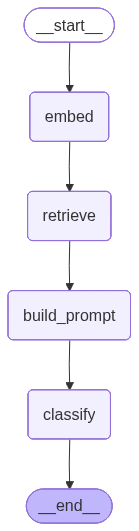

In [92]:
from IPython.display import Image, display
from classifier.graph import create_graph

# Criar o grafo para visualização
pipeline = create_graph(retriever, classifier, classes, representatives)

# Visualizar a estrutura do grafo LangGraph
display(Image(pipeline.get_graph().draw_mermaid_png()))

In [93]:
from classifier.graph import classify_ticket

In [94]:
# Classificar usando o pipeline completo
# A função classify_ticket encapsula todo o fluxo: retrieve → classify
details_graph = classify_ticket(
    ticket=query,
    retriever=retriever,
    classifier=classifier,
    classes=classes,
    reference_tickets=representatives,
)

print(f"Classe real: {true_class}")
print(f"Classe predita: {details_graph.result.classe}")
print(f"Justificativa: {details_graph.result.justificativa}")
if details_graph.reasoning:
    print(f"\nReasoning:")
    print(details_graph.reasoning)
print(f"\nCorreto: {details_graph.result.classe == true_class}")

Classe real: Access
Classe predita: Access
Justificativa: O ticket solicita a ativação de um cartão de acesso ('enable access card') com alta importância ('importance high'), correspondendo a padrões de solicitações de controle de acesso físico ou digital.

Reasoning:
First, the user has provided a ticket to classify: "enable access card for december pm enable card importance high hi please card thank unit". I need to classify this into one of the categories: Access, Administrative rights, HR Support, Hardware, Internal Project, Miscellaneous, Purchase, or Storage.

I must respond only with JSON in the format: {"classe": "<categoria>", "justificativa": "<explicação curta de 1-2 frases>"}.

The justification must be in Portuguese (Brazil) and mention keywords or patterns from the ticket that justify the classification.

Now, looking at the ticket: "enable access card for december pm enable card importance high hi please card thank unit". It seems to be about enabling an access card for 

## 7. Avaliação do Classificador

Agora vamos avaliar o desempenho do classificador nos 200 tickets de teste.

### Métricas Utilizadas

- **Accuracy:** Proporção de classificações corretas
- **F1 Macro:** Média não-ponderada do F1 por classe (trata todas as classes igualmente, importante para datasets desbalanceados)
- **Cohen's Kappa:** Mede concordância além do acaso (valores próximos de 1 indicam excelente concordância)
- **MCC (Matthews Correlation Coefficient):** Métrica robusta para classificação multi-classe
- **Confusion Matrix:** Visualiza erros de classificação entre classes

### Tratamento de Erros

LLMs podem ocasionalmente retornar JSON malformado, ou a API pode apresentar erros. Para lidar com isso:

**Erros de JSON (parsing):**
1. **Primeira tentativa:** Envia o prompt normal para a LLM
2. **Se JSON inválido:** Continua a conversa adicionando a resposta do assistant e um prompt de correção:
   ```
   Sua resposta anterior não está no formato JSON válido.
   Por favor, responda APENAS com JSON válido no formato:
   {"classe": "<categoria>", "justificativa": "<explicação>"}
   ```
3. **Segunda tentativa:** LLM recebe o contexto completo da conversa e tenta corrigir
4. **Se falhar novamente:** O ticket é marcado como erro e reportado separadamente

**Erros de API:**
- Erros de autenticação (401), rate limit (429), ou outros erros da API são capturados
- O ticket é marcado como erro com o motivo específico
- A avaliação continua com os próximos tickets

Este approach garante que:
- Um erro pontual não interrompe toda a avaliação
- A LLM tem chance de se corrigir com contexto adicional
- Erros persistentes são documentados para análise posterior

In [95]:
from classifier.metrics import evaluate, print_report, plot_confusion_matrix, plot_per_class_metrics
from classifier.runner import classify_batch

In [42]:
# Classificar todos os tickets de teste usando classify_batch()
results, classification_errors, total_tokens = classify_batch(
    test_df=test_df,
    retriever=retriever,
    classifier=classifier,
    classes=classes,
    reference_tickets=representatives,
    show_progress=True,
)

# Extrair y_true e y_pred para métricas
y_true = [r["true_class"] for r in results]
y_pred = [r["predicted_class"] for r in results]

print(f"\nClassificação concluída!")
print(f"Classificados com sucesso: {len(results)}")
if classification_errors:
    print(f"Erros de classificação (JSON inválido): {len(classification_errors)}")

print(f"\n{'='*60}")
print("TOKEN USAGE SUMMARY")
print(f"{'='*60}")
print(f"Prompt tokens:     {total_tokens.prompt_tokens:,}")
print(f"Completion tokens: {total_tokens.completion_tokens:,}")
print(f"Total tokens:      {total_tokens.total_tokens:,}")

Classifying: 100%|██████████| 200/200 [45:08<00:00, 13.54s/it, ok=1, pred=Storage]              


Classificação concluída!
Classificados com sucesso: 200

TOKEN USAGE SUMMARY
Prompt tokens:     165,417
Completion tokens: 200,988
Total tokens:      366,405


In [43]:
# Calcular métricas
metrics = evaluate(y_true, y_pred, classes)
print_report(metrics, classes)

RELATÓRIO DE AVALIAÇÃO

Accuracy:      0.7650
F1 Macro:      0.7582
Cohen's Kappa: 0.7314
MCC:           0.7350

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
                       precision    recall  f1-score   support

               Access       0.68      0.92      0.78        25
Administrative rights       0.75      0.36      0.49        25
           HR Support       0.71      0.88      0.79        25
             Hardware       0.57      0.68      0.62        25
     Internal Project       0.85      0.92      0.88        25
        Miscellaneous       0.82      0.72      0.77        25
             Purchase       0.95      0.84      0.89        25
              Storage       0.91      0.80      0.85        25

             accuracy                           0.77       200
            macro avg       0.78      0.77      0.76       200
         weighted avg       0.78      0.77     

### Interpretação das Métricas Gerais

Os resultados da avaliação indicam um classificador com **performance sólida**:

| Métrica | Valor | Interpretação |
|---------|-------|---------------|
| **Accuracy** | 76.5% | ~3 em 4 tickets classificados corretamente |
| **F1 Macro** | 75.8% | Performance equilibrada entre classes (não favorece majoritárias) |
| **Cohen's Kappa** | 0.73 | Concordância **substancial** (escala: >0.6 bom, >0.8 excelente) |
| **MCC** | 0.74 | Confirma robustez - métrica equilibrada para problemas multiclasse |

**Destaques por classe:**
- **Maior recall:** Access (92%) e Internal Project (92%) - o modelo raramente perde tickets dessas classes
- **Maior precision:** Purchase (95%) - quando prediz Purchase, quase sempre acerta
- **Classe problemática:** Administrative rights (F1=49%) - recall de apenas 36%, indicando que muitos tickets dessa classe são classificados incorretamente

### Baseline: RAG-only com votacao ponderada

Avaliamos o desempenho da classificacao direta via retrieval, sem LLM,
usando a mesma configuracao de K similares.


### Comparação: RAG+LLM vs Baseline (Weighted Vote)

| Aspecto | RAG + LLM | Baseline |
|---------|-----------|----------|
| Accuracy | 76.5% | **77.5%** |
| F1 Macro | 75.8% | **77.6%** |
| Tokens consumidos | 366k | 0 |
| Tempo de execução | ~45 min | ~2 seg |
| Justificativas | **Sim** | Não |

**Insights:**

1. **Métricas numéricas:** A baseline supera ligeiramente o RAG+LLM. Isso indica que o retriever já captura bem a semântica dos tickets - a LLM não adiciona acurácia significativa.

2. **Valor agregado da LLM:** O diferencial está nas **justificativas em linguagem natural**. Para sistemas de suporte, explicar *por que* um ticket foi classificado é tão importante quanto a classificação em si.

3. **Trade-off custo/benefício:** A LLM consome tokens e tempo, mas oferece interpretabilidade. Em produção, uma abordagem híbrida pode ser ideal: usar weighted vote para triagem rápida e LLM apenas quando justificativa for necessária.

4. **Erros similares:** Ambos os métodos têm dificuldade com Administrative rights, sugerindo que o problema está na representação semântica dessa classe, não na capacidade da LLM.

In [44]:
from classifier.config import K_SIMILAR
from tqdm import tqdm

weighted_preds = []
for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Classificando (weighted vote)"):
    similar = retriever.retrieve(row["Document"], k=K_SIMILAR)
    vote = retriever.weighted_vote(similar)
    weighted_preds.append(vote["predicted_class"])

y_true_weighted = test_df["Topic_group"].tolist()
metrics_weighted = evaluate(y_true_weighted, weighted_preds, classes)
print_report(metrics_weighted, classes)


Classificando (weighted vote): 100%|██████████| 200/200 [00:01<00:00, 122.55it/s]

RELATÓRIO DE AVALIAÇÃO

Accuracy:      0.7750
F1 Macro:      0.7765
Cohen's Kappa: 0.7429
MCC:           0.7462

------------------------------------------------------------
Classification Report:
------------------------------------------------------------
                       precision    recall  f1-score   support

               Access       0.81      0.88      0.85        25
Administrative rights       0.86      0.48      0.62        25
           HR Support       0.65      0.88      0.75        25
             Hardware       0.53      0.72      0.61        25
     Internal Project       0.87      0.80      0.83        25
        Miscellaneous       0.83      0.80      0.82        25
             Purchase       1.00      0.88      0.94        25
              Storage       0.86      0.76      0.81        25

             accuracy                           0.78       200
            macro avg       0.80      0.78      0.78       200
         weighted avg       0.80      0.78     

### Baseline: Graficos (weighted vote)

Visualizacao por classe e confusion matrix para a baseline RAG-only.


In [45]:
# Graficos por classe - weighted vote
plot_per_class_metrics(
    y_true_weighted,
    weighted_preds,
    classes,
    title="Precision, Recall e F1-Score por Classe - Weighted Vote"
)


In [46]:
# Confusion matrix - weighted vote
plot_confusion_matrix(
    metrics_weighted["confusion_matrix"],
    classes,
    title="Confusion Matrix - Weighted Vote"
)


### Métricas por Classe

O gráfico abaixo mostra precision, recall e F1-score para cada classe, facilitando a identificação visual de quais classes têm melhor/pior desempenho.

In [47]:
# Gráfico de métricas por classe
plot_per_class_metrics(y_true, y_pred, classes, title="Precision, Recall e F1-Score por Classe")

In [48]:
# Visualizar confusion matrix
plot_confusion_matrix(metrics["confusion_matrix"], classes, title="Confusion Matrix - Classificador RAG")

### Análise da Matriz de Confusão

A matriz de confusão normalizada revela padrões importantes:

**Classes bem separadas (diagonal forte):**
- **Internal Project (92%):** Tickets com códigos de projeto são distintivos
- **Purchase (84%):** Vocabulário específico (PO, purchase order) facilita identificação
- **Access (92%):** Padrões como "access card", "password reset" são claros

**Principais confusões:**

| Confusão | Ocorrências | Possível causa |
|----------|-------------|----------------|
| Admin rights → Hardware | 12 (48%) | Tickets de "upgrade" e "update" aparecem em ambas |
| Miscellaneous → HR Support | 4 | Tickets administrativos genéricos |
| Storage → Access | 3 | Ambas tratam de "acesso" a recursos |

**Observações:**
- **Administrative rights** é a classe mais problemática: apenas 36% de recall
- **Miscellaneous** funciona como classe "catch-all", capturando tickets que não se encaixam claramente em outras categorias
- A confusão Hardware/Admin rights sugere que upgrades de **software** (Admin rights) são confundidos com upgrades de **hardware**

### Confusion Matrix Normalizada

A versão normalizada mostra percentagens em vez de contagens absolutas, facilitando a identificação de taxas de erro por classe.

In [49]:
# Confusion matrix normalizada (percentagens)
plot_confusion_matrix(
    metrics["confusion_matrix"], 
    classes, 
    title="Confusion Matrix - Normalizada por True Label",
    normalize=True
)

### Análise de Erros

Existem dois tipos de erros na avaliação:

1. **Erros de classificação:** A LLM retornou um JSON válido, mas a classe predita difere da classe real
2. **Erros de parsing:** A LLM não retornou JSON válido mesmo após retry (tickets não incluídos nas métricas)

Abaixo analisamos os erros de classificação para entender os padrões de confusão entre classes.

In [50]:
# Filtrar erros
errors = [r for r in results if not r["correct"]]
print(f"Total de erros: {len(errors)} de {len(results)} ({100 * len(errors) / len(results):.1f}%)\n")

# Mostrar alguns exemplos de erros
print("=" * 80)
print("EXEMPLOS DE ERROS DE CLASSIFICAÇÃO")
print("=" * 80)

for i, error in enumerate(errors[:5], 1):
    print(f"\n--- Erro {i} ---")
    print(f"Classe real:     {error['true_class']}")
    print(f"Classe predita:  {error['predicted_class']}")
    print(f"Justificativa:   {error['justification']}")
    print(f"Ticket:          {error['ticket'][:200]}...")

Total de erros: 47 de 200 (23.5%)

EXEMPLOS DE ERROS DE CLASSIFICAÇÃO

--- Erro 1 ---
Classe real:     Access
Classe predita:  Purchase
Justificativa:   O ticket menciona a desativação da funcionalidade de criação de pedidos na visão do comprador, envolvendo controles SOX relacionados a processos de compra.
Ticket:          create order or disabled from the buyer view tuesday march please disable dears please content regards analyst tuesday march please disable hi please investigate create order feature disabled buyer vi...

--- Erro 2 ---
Classe real:     Access
Classe predita:  HR Support
Justificativa:   O ticket menciona 'access card enabling' para um 're starter' em um centro, indicando uma solicitação de suporte para novos funcionários, comum em processos de integração.
Ticket:          access card enabling wednesday november re starter card enabling center va card la si exact card si card personal...

--- Erro 3 ---
Classe real:     Administrative rights
Classe predita:  Hardwar

### Padrões nos Erros de Classificação

Analisando os 47 erros (23.5% do total), identificamos padrões recorrentes:

**1. Administrative rights → Hardware (12 erros)**
Exemplos mostram tickets sobre "upgrade", "update", "performance issues" que semanticamente poderiam pertencer a ambas:
- *"oracle upgrade zones"* → classificado como Hardware
- *"windows upgrade failed"* → classificado como Hardware
- *"performance issues after upgrading endpoint tool"* → classificado como Hardware

**2. Miscellaneous → HR Support (4 erros)**
Tickets administrativos genéricos que mencionam aprovações ou configurações de usuário.

**3. Purchase → Internal Project (3 erros)**
Confusão entre códigos de projeto e ordens de compra (PO), já que ambos envolvem códigos e formulários.

**Insight principal:**
Os limites semânticos entre certas classes são **inerentemente ambíguos**. Um ticket sobre "upgrade do Windows" pode ser:
- **Administrative rights:** se for sobre permissões para fazer upgrade
- **Hardware:** se for sobre o processo técnico de upgrade

Essa ambiguidade está no próprio dataset, não apenas no classificador.

**Erros coerentes com julgamento humano:**
As justificativas geradas pelo modelo para os erros são **razoáveis e bem fundamentadas**. Um exemplo ilustrativo: o ticket *"performance issues... after upgrading endpoint tool takes up cpu makes work impossible android studio..."* (classe real: Administrative rights) foi classificado como Hardware com a justificativa *"O ticket relata problemas de desempenho devido ao consumo excessivo de CPU pela ferramenta de endpoint após uma atualização, impossibilitando o trabalho em ambientes como Android Studio, o que está relacionado a recursos de hardware"*. A menção a CPU, problemas de desempenho e impossibilidade de trabalhar são sintomas tipicamente associados a limitações de hardware — um classificador humano facilmente chegaria à mesma conclusão. Os erros não são aleatórios ou absurdos — são confusões compreensíveis em zonas de fronteira semântica, onde a própria definição das classes no dataset é ambígua.

In [51]:
# Distribuição de erros por classe
from collections import Counter

print("Distribuição de erros por classe real:")
error_by_true = Counter(e["true_class"] for e in errors)
for cls, count in sorted(error_by_true.items(), key=lambda x: -x[1]):
    print(f"  {cls}: {count} erros")

print("\nConfusões mais comuns (real → predito):")
confusion_pairs = Counter((e["true_class"], e["predicted_class"]) for e in errors)
for (true, pred), count in confusion_pairs.most_common(10):
    print(f"  {true} → {pred}: {count}x")

Distribuição de erros por classe real:
  Administrative rights: 16 erros
  Hardware: 8 erros
  Miscellaneous: 7 erros
  Storage: 5 erros
  Purchase: 4 erros
  HR Support: 3 erros
  Access: 2 erros
  Internal Project: 2 erros

Confusões mais comuns (real → predito):
  Administrative rights → Hardware: 12x
  Miscellaneous → HR Support: 4x
  Purchase → Internal Project: 3x
  Storage → Access: 3x
  Administrative rights → HR Support: 2x
  HR Support → Access: 2x
  Hardware → Access: 2x
  Hardware → HR Support: 2x
  Miscellaneous → Access: 2x
  Access → Purchase: 1x


### Relação entre Similaridade e Acertos

A análise dos scores de similaridade revela uma correlação clara:

| Predições | Similaridade Média | Similaridade Mediana |
|-----------|-------------------|---------------------|
| **Corretas** | 0.776 | 0.778 |
| **Incorretas** | 0.674 | 0.671 |

**Diferença: ~13% menor para predições incorretas**

**Interpretação:**
1. Quando o retriever encontra tickets **muito similares** (score alto), a classificação tende a ser correta
2. Tickets com **baixa similaridade** aos exemplos do treino são mais propensos a erros
3. Esses tickets "difíceis" provavelmente são:
   - Atípicos ou outliers dentro de sua classe
   - Semanticamente ambíguos (pertencem a zonas de fronteira entre classes)

### Distribuição de Erros por Classe

Visualização gráfica dos erros por classe real, facilitando a identificação de quais classes são mais difíceis de classificar corretamente.

In [52]:
import plotly.express as px

# Gráfico de erros por classe
if errors:
    error_data = [{"Classe": cls, "Erros": count} for cls, count in error_by_true.items()]
    fig = px.bar(
        error_data, 
        x="Erros", 
        y="Classe", 
        orientation="h",
        title="Erros por Classe Real",
        color="Erros",
        color_continuous_scale="Reds"
    )
    fig.update_layout(height=350, showlegend=False)
    fig.show()
else:
    print("Nenhum erro de classificação para exibir!")

### Análise de Scores de Similaridade

Comparação dos scores de similaridade entre predições corretas e incorretas. Scores mais baixos em predições incorretas indicam que o retriever teve dificuldade em encontrar exemplos relevantes. Se os scores são similares, o problema está na classificação do LLM.

In [53]:
import numpy as np
import plotly.graph_objects as go

# Calcular média dos scores de similaridade por predição
def mean_similarity(result):
    scores = [t['score'] for t in result['similar_tickets']]
    return np.mean(scores) if scores else 0

scores_correct = [mean_similarity(r) for r in results if r['correct']]
scores_incorrect = [mean_similarity(r) for r in results if not r['correct']]

# Box plot comparativo
fig = go.Figure()
fig.add_trace(go.Box(y=scores_correct, name='Corretos', marker_color='#2ca02c'))
fig.add_trace(go.Box(y=scores_incorrect, name='Incorretos', marker_color='#d62728'))

fig.update_layout(
    title='Distribuição de Scores de Similaridade (Média dos K Similares)',
    yaxis_title='Score de Similaridade',
    height=400
)
fig.show()

# Estatísticas
print(f"Corretos:   média={np.mean(scores_correct):.3f}, mediana={np.median(scores_correct):.3f}, n={len(scores_correct)}")
if scores_incorrect:
    print(f"Incorretos: média={np.mean(scores_incorrect):.3f}, mediana={np.median(scores_incorrect):.3f}, n={len(scores_incorrect)}")
else:
    print("Nenhuma predição incorreta para análise.")

Corretos:   média=0.776, mediana=0.778, n=153
Incorretos: média=0.674, mediana=0.671, n=47


### Análise de Similaridade por Classe em Predições Erradas

Para cada predição incorreta, comparamos a similaridade do ticket com:
- **Classe predita**: A classe que o modelo escolheu incorretamente
- **Classe real**: A classe correta do ticket

Isso ajuda a entender se o erro foi "justificado" pelo RAG (similaridade alta com a classe predita) ou se o LLM cometeu um erro apesar dos sinais do RAG.

In [54]:
# Análise de similaridade por classe para predições erradas
if errors:
    # Para cada erro, calcular similaridade com classe predita e classe real
    similarity_data = []

    for error in errors:
        ticket_text = error['ticket']
        pred_class = error['predicted_class']
        true_class = error['true_class']

        # Similaridade com classe predita
        pred_sim = retriever.compute_class_similarity(ticket_text, pred_class, k=5)
        # Similaridade com classe real
        true_sim = retriever.compute_class_similarity(ticket_text, true_class, k=5)

        similarity_data.append({
            'ticket': ticket_text[:100] + '...',
            'pred_class': pred_class,
            'true_class': true_class,
            'similarity_pred': pred_sim['mean_score'],
            'similarity_true': true_sim['mean_score'],
            'difference': pred_sim['mean_score'] - true_sim['mean_score'],
        })

    sim_df = pd.DataFrame(similarity_data)

    # Visualização: Box plot comparando as duas similaridades
    fig = go.Figure()
    fig.add_trace(go.Box(
        y=sim_df['similarity_pred'],
        name='Classe Predita',
        marker_color='#d62728'
    ))
    fig.add_trace(go.Box(
        y=sim_df['similarity_true'],
        name='Classe Real',
        marker_color='#2ca02c'
    ))

    fig.update_layout(
        title='Similaridade por Classe em Predições Erradas',
        yaxis_title='Score de Similaridade (média top-K)',
        height=400
    )
    fig.show()

    # Estatísticas
    print(f"Similaridade com classe predita: média={sim_df['similarity_pred'].mean():.3f}, "
          f"mediana={sim_df['similarity_pred'].median():.3f}")
    print(f"Similaridade com classe real:   média={sim_df['similarity_true'].mean():.3f}, "
          f"mediana={sim_df['similarity_true'].median():.3f}")

    # Análise: Quantos erros têm maior similaridade com a predita?
    higher_pred_sim = (sim_df['similarity_pred'] > sim_df['similarity_true']).sum()
    print(f"\nErros com maior similaridade à classe predita: {higher_pred_sim}/{len(errors)} "
          f"({100*higher_pred_sim/len(errors):.1f}%)")
else:
    print("Nenhum erro de classificação para análise de similaridade.")

Similaridade com classe predita: média=0.633, mediana=0.621
Similaridade com classe real:   média=0.605, mediana=0.605

Erros com maior similaridade à classe predita: 31/47 (66.0%)


## 8. Conclusões e Insights

### Resumo dos Resultados

O sistema RAG+LLM alcançou **76.5% de accuracy** e **75.8% de F1 Macro** na classificação de tickets de suporte, com performance comparável à baseline de votação ponderada (77.5% accuracy).

### Principais Descobertas

1. **O retriever é o componente crítico:** A baseline sem LLM teve performance similar, indicando que a qualidade dos embeddings e do retrieval determina o sucesso da classificação.

2. **Valor da LLM está na explicabilidade:** O diferencial do RAG+LLM são as justificativas em linguagem natural, essenciais para sistemas de suporte onde transparência é importante.

3. **Classe problemática:** Administrative rights apresenta apenas 36% de recall, com 48% dos erros sendo confundidos com Hardware. A semântica de "upgrade" e "update" é compartilhada entre essas classes.

4. **Similaridade como confiança:** Scores de similaridade mais baixos correlacionam com erros, sugerindo que esse valor pode ser usado como indicador de confiança.

5. **66% dos erros são "justificados":** Em mais da metade dos erros, o ticket tinha maior similaridade com a classe predita do que com a classe real, indicando ambiguidade inerente ao dataset.